In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                     std=[0.5, 0.5, 0.5])])
                
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = transforms,
                                             download = True)

test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = transforms,
                                            download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

NameError: name 'torch' is not defined

## Part1

In [4]:
# Creating CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 32 7x7 filters followed by 2x2 max pooling
        # W' = (W - F + 2P) / S + 1       initial W is 32
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7) # (32-7+2*0)/1+1 = 26
        
        # nn.Mish(),
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # (26-2+2*0)/2+1 = 13

        # two 64 3x3 filters
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # (13-3+2*0)/1+1 = 11

        self.convolution3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3) # (11-3+2*0)/1+1 = 9
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # (9-2+2*0)/2+1 = 4

        self.fc = nn.Linear(64*4*4, 10)
        self.mish = nn.Mish()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
    
    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_uniform_(module.weight)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight)
         
    def forward(self, x):
        x = self.convolution1(x)
        x = self.pool1(x)
        x = self.mish(self.convolution2(x))
        x = self.mish(self.pool2(self.convolution3(x)))
                
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

loss_function = torch.nn.CrossEntropyLoss()
model = CNN().to(device)
model.initialize()
optimizer = torch.optim.Adam(model.parameters())

In [5]:

def train(model):
    all_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_function(outputs, labels)
        all_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Train Loss: {all_loss/len(train_loader)}")
    return all_loss/len(train_loader)

def test(model):
    #all_loss = 0
    accuracy = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):  
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            #loss = loss_function(outputs, labels)
            #all_loss += loss.item()

            prediction = outputs.argmax(dim=1)
            accuracy.append((labels==prediction).sum().item() / labels.shape[0])
    print(f"Test Accuracy: {sum(accuracy)/len(accuracy)}") #  Test Loss: {all_loss/len(test_loader)}
    return sum(accuracy)/len(accuracy)
        

In [6]:
num_epochs = 20

train_loss_CNN = []
test_accuracy_CNN = []
for epoch in tqdm(range(num_epochs)):
    loss = train(model)
    train_loss_CNN.append(loss)
    accuracy = test(model)
    test_accuracy_CNN.append(accuracy)
    print('\n')

  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.0455376385422923
Test Accuracy: 0.4817874203821656


Train Loss: 1.9446989842083142
Test Accuracy: 0.5362261146496815


Train Loss: 1.9041826563418065
Test Accuracy: 0.5607085987261147


Train Loss: 1.8826376900953405
Test Accuracy: 0.5638933121019108


Train Loss: 1.859487524422843
Test Accuracy: 0.5933519108280255


Train Loss: 1.8405252466421298
Test Accuracy: 0.5979299363057324


Train Loss: 1.829617742687235
Test Accuracy: 0.59484474522293


Train Loss: 1.8207104431698695
Test Accuracy: 0.6084792993630573


Train Loss: 1.8129007698934707
Test Accuracy: 0.6145501592356688


Train Loss: 1.7999518585327032
Test Accuracy: 0.6284832802547771


Train Loss: 1.7975693974653473
Test Accuracy: 0.5998208598726115


Train Loss: 1.788422469287882
Test Accuracy: 0.623109076433121


Train Loss: 1.7871669671114754
Test Accuracy: 0.6413216560509554


Train Loss: 1.7820441358534576
Test Accuracy: 0.6404259554140127


Train Loss: 1.7783465781785033
Test Accuracy: 0.631468949044586


Tr

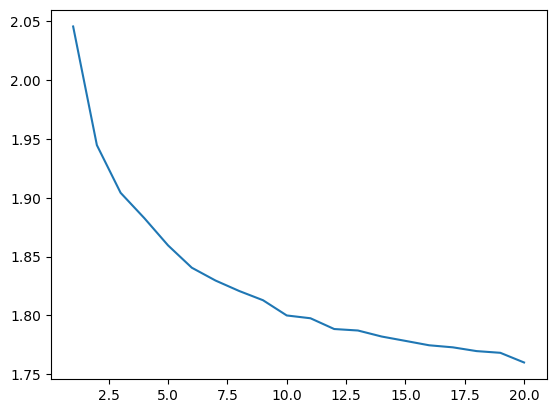

In [7]:
plt.plot(range(1, num_epochs+1), train_loss_CNN)
plt.show()

torch.Size([32, 3, 7, 7])


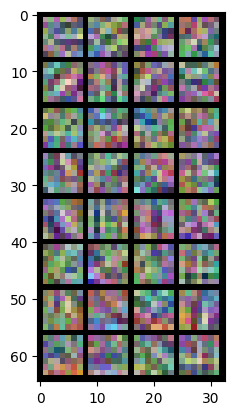

In [8]:
def visualize_filters(model):
    layer = model.convolution1.cpu()
    weight_tensor = layer.weight.detach().clone()
    print(weight_tensor.shape)
    # Ht' = Ht/(2|Ht| + e) + 0.5
    weight_tensor = weight_tensor/((torch.norm(weight_tensor, p=torch.inf) + 0.0001)*2) + 0.5
    visual = torchvision.utils.make_grid(weight_tensor, nrow=4, padding=1)
    plt.imshow(visual.numpy().transpose((1, 2, 0)))

visualize_filters(model)

## Part2

In [9]:
# Creating CNN with batch norm
class CNN_batchnorm(nn.Module):
    def __init__(self):
        super(CNN_batchnorm, self).__init__()
        
        # 32 7x7 filters followed by 2x2 max pooling
        # W' = (W - F + 2P) / S + 1       initial W is 32
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7) # (32-7+2*0)/1+1 = 26
        self.conv1_bn = nn.BatchNorm2d(32)
        # nn.Mish(),
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # (26-2+2*0)/2+1 = 13

        # two 64 3x3 filters
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # (13-3+2*0)/1+1 = 11
        self.conv2_bn = nn.BatchNorm2d(64)
        self.convolution3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3) # (11-3+2*0)/1+1 = 9
        self.conv3_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # (9-2+2*0)/2+1 = 4

        self.fc = nn.Linear(64*4*4, 10)
        self.mish = nn.Mish()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
    
    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_uniform_(module.weight)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight)
          
    def forward(self, x):
        x = self.conv1_bn(self.convolution1(x))
        x = self.pool1(x)
        x = self.conv2_bn(self.mish(self.convolution2(x)))
        x = self.conv3_bn(self.mish(self.pool2(self.convolution3(x))))
                
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

loss_function = torch.nn.CrossEntropyLoss()
model_batchnorm = CNN_batchnorm().to(device)
model_batchnorm.initialize()
optimizer = torch.optim.Adam(model_batchnorm.parameters())

In [10]:
train_loss_CNN_batchnorm = []
test_accuracy_CNN_batchnorm = []
for epoch in tqdm(range(num_epochs)):
    loss = train(model_batchnorm)
    train_loss_CNN_batchnorm.append(loss)
    accuracy = test(model_batchnorm)
    test_accuracy_CNN_batchnorm.append(accuracy)
    print('\n')


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.0029644181051522
Test Accuracy: 0.5151273885350318


Train Loss: 1.8944226930208523
Test Accuracy: 0.5783240445859873


Train Loss: 1.852025424885323
Test Accuracy: 0.6147492038216561


Train Loss: 1.8242967717178034
Test Accuracy: 0.611265923566879


Train Loss: 1.8021035147140094
Test Accuracy: 0.6479896496815286


Train Loss: 1.7848849374315012
Test Accuracy: 0.6475915605095541


Train Loss: 1.7713773599670977
Test Accuracy: 0.6474920382165605


Train Loss: 1.7611360981336335
Test Accuracy: 0.6700835987261147


Train Loss: 1.7491227493566626
Test Accuracy: 0.6649084394904459


Train Loss: 1.7404978862199028
Test Accuracy: 0.6681926751592356


Train Loss: 1.734422755820672
Test Accuracy: 0.6758558917197452


Train Loss: 1.723690927333539
Test Accuracy: 0.6698845541401274


Train Loss: 1.7201290688551296
Test Accuracy: 0.6757563694267515


Train Loss: 1.7101298285567241
Test Accuracy: 0.6799363057324841


Train Loss: 1.7028120545779957
Test Accuracy: 0.679140127388535




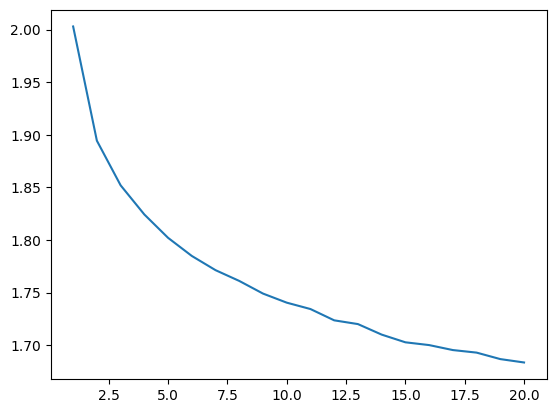

torch.Size([32, 3, 7, 7])


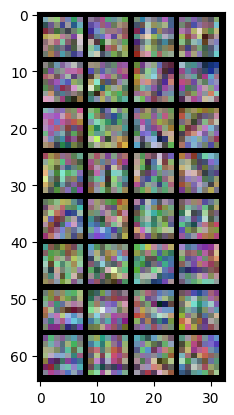

In [11]:
plt.plot(range(1, num_epochs+1), train_loss_CNN_batchnorm)
plt.show()
visualize_filters(model_batchnorm)

## Part3

In [35]:
# Creating CNN with more
class CNN_new(nn.Module):
    def __init__(self):
        super(CNN_new, self).__init__()
        
        # W' = (W - F + 2P) / S + 1       initial W is 32
        
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.convolution_16_16_3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
        self.convolution_16_32_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.convolution_32_32_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.convolution_32_64_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.convolution_64_64_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        self.max_pool_2_2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.avg_pool_2_2 = nn.AvgPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.mish = nn.Mish()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        
        self.conv_bn_16 = nn.GroupNorm(4, 16)
        self.conv_bn_32 = nn.GroupNorm(8, 32)
        self.conv_bn_64 = nn.GroupNorm(16, 64)
        self.conv_bn_fc = nn.GroupNorm(32, 128)
    
    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_uniform_(module.weight)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight)
          
    def forward(self, x):
        x = self.conv_bn_16(self.convolution1(x)) # (32 - 3)/1 + 1 = 30
        x = self.conv_bn_32(self.mish(self.convolution_16_32_3(x))) # (30 - 3)/1 + 1 = 28
        x = self.conv_bn_32(self.mish(self.convolution_32_32_3(x))) # (28 - 3)/1 + 1 = 26
        x = self.max_pool_2_2(x) # (26 - 2)/2 + 1 = 13
        
        x = self.conv_bn_64(self.mish(self.convolution_32_64_3(x))) # (13 - 3)/1 + 1 = 11
        x = self.conv_bn_64(self.mish(self.convolution_64_64_3(x))) # (11 - 3)/1 + 1 = 9
        x = self.avg_pool_2_2(x) # (9 - 2)/2 + 1 = 4
                
        x = self.flatten(x)
        x = self.conv_bn_fc(self.mish(self.fc1(x)))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

loss_function = torch.nn.CrossEntropyLoss()
model_new = CNN_new().to(device)
model_new.initialize()
optimizer = torch.optim.AdamW(model_new.parameters())

In [36]:
train_loss_CNN_new = []
test_accuracy_CNN_new = []
for epoch in tqdm(range(num_epochs)):
    loss = train(model_new)
    train_loss_CNN_new.append(loss)
    accuracy = test(model_new)
    test_accuracy_CNN_new.append(accuracy)
    print('\n')

  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.002838675933116
Test Accuracy: 0.542296974522293
Train Loss: 1.874984378857381
Test Accuracy: 0.5890724522292994
Train Loss: 1.823106138602547
Test Accuracy: 0.65515525477707
Train Loss: 1.786342174348319
Test Accuracy: 0.6578423566878981
Train Loss: 1.7609287994292082
Test Accuracy: 0.6823248407643312
Train Loss: 1.7406446328553398
Test Accuracy: 0.6781449044585988
Train Loss: 1.7254534081729782
Test Accuracy: 0.7027269108280255
Train Loss: 1.7085759153451456
Test Accuracy: 0.7192476114649682
Train Loss: 1.6982054689046366
Test Accuracy: 0.7242237261146497
Train Loss: 1.6889462039598724
Test Accuracy: 0.7113853503184714
Train Loss: 1.6757132918633464
Test Accuracy: 0.7250199044585988
Train Loss: 1.6682815161507454
Test Accuracy: 0.7338773885350318
Train Loss: 1.6597491068303432
Test Accuracy: 0.7267117834394905
Train Loss: 1.6507289174877469
Test Accuracy: 0.7334792993630573
Train Loss: 1.648370578160981
Test Accuracy: 0.7398487261146497
Train Loss: 1.6380077579137309
Te

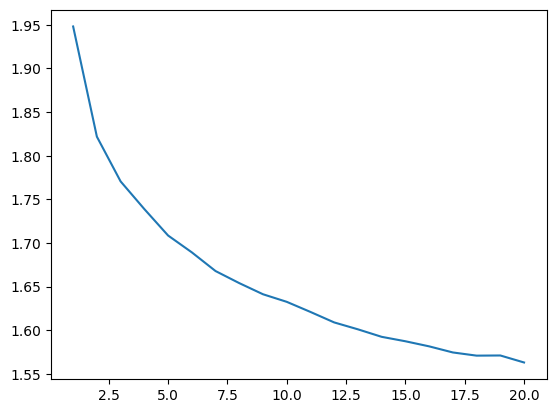

torch.Size([16, 3, 3, 3])


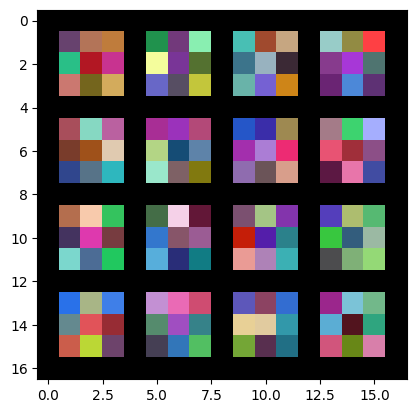

In [14]:
plt.plot(range(1, num_epochs+1), train_loss_CNN_new)
plt.show()
visualize_filters(model_new)

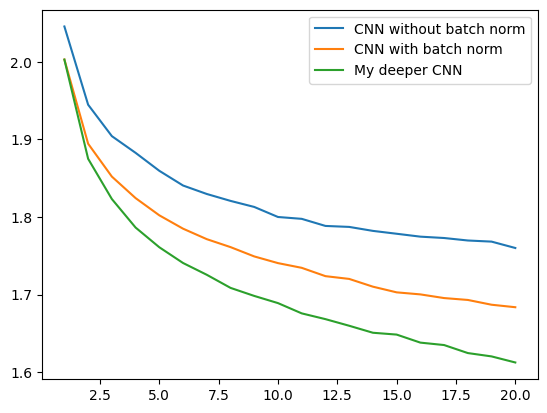

In [37]:
plt.plot(range(1, num_epochs+1), train_loss_CNN, label="CNN without batch norm")
plt.plot(range(1, num_epochs+1), train_loss_CNN_batchnorm, label="CNN with batch norm")
plt.plot(range(1, num_epochs+1), train_loss_CNN_new, label="My deeper CNN")
plt.legend()
plt.show()

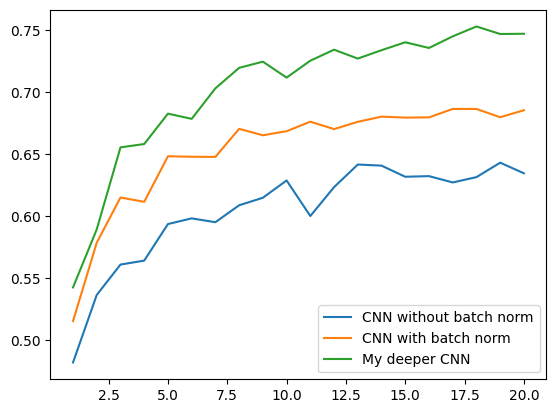

In [38]:
plt.plot(range(1, num_epochs+1), test_accuracy_CNN, label="CNN without batch norm")
plt.plot(range(1, num_epochs+1), test_accuracy_CNN_batchnorm, label="CNN with batch norm")
plt.plot(range(1, num_epochs+1), test_accuracy_CNN_new, label="My deeper CNN")
plt.legend()
plt.show()